In [1]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import os

os.makedirs("tea_chunks_planet", exist_ok=True)

embeddings_df = pd.read_parquet(
    "gs://demeter-labs/tea/classifier-datasets/planet_tile_classifier_dataset_v2_java-sumatra_80m_embeddings.parquet")


In [44]:
pivot_embeddings = embeddings_df.pivot_table(
    index='id', columns='time_period', values=['embedding'])
label_df = embeddings_df[['id', 'label']].drop_duplicates()

In [45]:
label_df.shape

(174851, 2)

In [46]:
feature_cols = [col for col in pivot_embeddings.columns if 'embedding' in col]

In [47]:
print("Shape before dropping NaNs:", pivot_embeddings.shape)
pivot_embeddings = pivot_embeddings.dropna()
print("Shape after dropping NaNs:", pivot_embeddings.shape)
pivot_embeddings

Shape before dropping NaNs: (174851, 12)
Shape after dropping NaNs: (174779, 12)


embedding  \
time_period                                            2023_09   
id                                                               
qpxuph7ep4h  [0.05909111723303795, 0.19025008380413055, -0....   
qpxupj3ss1g  [0.05844511836767197, 0.1955217570066452, -0.7...   
qpxupjmud1v  [0.08577091246843338, 0.18935251235961914, -0....   
qpxupn3n138  [0.06899339705705643, 0.1891365647315979, -0.7...   
qpxuqfssp03  [0.07136784493923187, 0.19697673618793488, -0....   
...                                                        ...   
w20581k3qme  [-0.08103862404823303, 0.20431281626224518, -0...   
w20583bdhm6  [-0.06676419079303741, 0.2051677703857422, -0....   
w20585vj1hy  [-0.0647759810090065, 0.20689289271831512, -0....   
w2058h6vyhw  [-0.09175382554531097, 0.20448756217956543, -0...   
w2058hfywhw  [-0.0935899019241333, 0.20957344770431519, -0....   

                                                                \
time_period                                            2023_10   
id                                                               
qpxuph7ep4h  [-0.5395063161849976, 0.24671924114227295, -1....   
qpxupj3ss1g  [-0.48600634932518005, 0.24846269190311432, -1...   
qpxupjmud1v  [-0.5237690806388855, 0.24591098725795746, -1....   
qpxupn3n138  [-0.5435152649879456, 0.24576321244239807, -1....   
qpxuqfssp03  [-0.1273689866065979, 0.22756370902061462, -1....   
...                                                        ...   
w20581k3qme  [-0.06943371891975403, 0.21083824336528778, -0...   
w20583bdhm6  [-0.05889784172177315, 0.2145497351884842, -0....   
w20585vj1hy  [-0.05544349178671837, 0.21994423866271973, -0...   
w2058h6vyhw  [-0.09683530777692795, 0.22285467386245728, -1...   
w2058hfywhw  [-0.0956919863820076, 0.2228804975748062, -1.0...   

                                                                \
time_period                                            2023_11   
id                                                               
qpxuph7ep4h  [-0.016400139778852463, 0.20025403797626495, -...   
qpxupj3ss1g  [0.043872036039829254, 0.19295282661914825, -0...   
qpxupjmud1v  [0.04009084403514862, 0.1848607212305069, -0.8...   
qpxupn3n138  [0.0363764762878418, 0.2009657323360443, -0.84...   
qpxuqfssp03  [0.018600638955831528, 0.199296236038208, -0.8...   
...                                                        ...   
w20581k3qme  [-0.04669841378927231, 0.20241710543632507, -0...   
w20583bdhm6  [-0.03566974028944969, 0.20061521232128143, -0...   
w20585vj1hy  [-0.021513236686587334, 0.20526070892810822, -...   
w2058h6vyhw  [-0.04282202571630478, 0.2110486626625061, -0....   
w2058hfywhw  [-0.013697903603315353, 0.20705516636371613, -...   

                                                                \
time_period                                            2023_12   
id                                                               
qpxuph7ep4h  [-0.21347254514694214, 0.22851428389549255, -1...   
qpxupj3ss1g  [-0.2368517369031906, 0.2337489128112793, -1.1...   
qpxupjmud1v  [-0.2669239640235901, 0.237248495221138, -1.18...   
qpxupn3n138  [-0.28650471568107605, 0.2387237846851349, -1....   
qpxuqfssp03  [-0.3180103898048401, 0.24368375539779663, -1....   
...                                                        ...   
w20581k3qme  [-0.1977377086877823, 0.22269941866397858, -1....   
w20583bdhm6  [-0.09860594570636749, 0.2153509110212326, -0....   
w20585vj1hy  [-0.07831864804029465, 0.20759636163711548, -0...   
w2058h6vyhw  [-0.1644560694694519, 0.21475455164909363, -0....   
w2058hfywhw  [-0.08585404604673386, 0.21422602236270905, -0...   

                                                                \
time_period                                            2024_01   
id                                                               
qpxuph7ep4h  [0.022084452211856842, 0.1972484290599823, -0....   
qpxupj3ss1g  [0.032316967844963074, 0.192986860871315, -0.8...   
qpxupjmud1v  [0.0289114

In [56]:
# 2. Reshape the array
num_rows = pivot_embeddings.shape[0]  # Original number of rows
num_cols = pivot_embeddings.shape[1] 
array_len = len(pivot_embeddings.iloc[0, 0])
#reshaped_array = all_arrays.reshape(num_rows, num_cols * array_len) #old line
reshaped_array = all_arrays #no reshape needed since hstack performed the reshape implicitly

# 3. Create a new DataFrame
new_column_names = [f"{col[0]}_{col[1]}_{i}" for col in pivot_embeddings.columns for i in range(array_len)]
new_column_names

['embedding_2023_09_0',
 'embedding_2023_09_1',
 'embedding_2023_09_2',
 'embedding_2023_09_3',
 'embedding_2023_09_4',
 'embedding_2023_09_5',
 'embedding_2023_09_6',
 'embedding_2023_09_7',
 'embedding_2023_09_8',
 'embedding_2023_09_9',
 'embedding_2023_09_10',
 'embedding_2023_09_11',
 'embedding_2023_09_12',
 'embedding_2023_09_13',
 'embedding_2023_09_14',
 'embedding_2023_09_15',
 'embedding_2023_09_16',
 'embedding_2023_09_17',
 'embedding_2023_09_18',
 'embedding_2023_09_19',
 'embedding_2023_09_20',
 'embedding_2023_09_21',
 'embedding_2023_09_22',
 'embedding_2023_09_23',
 'embedding_2023_09_24',
 'embedding_2023_09_25',
 'embedding_2023_09_26',
 'embedding_2023_09_27',
 'embedding_2023_09_28',
 'embedding_2023_09_29',
 'embedding_2023_09_30',
 'embedding_2023_09_31',
 'embedding_2023_09_32',
 'embedding_2023_09_33',
 'embedding_2023_09_34',
 'embedding_2023_09_35',
 'embedding_2023_09_36',
 'embedding_2023_09_37',
 'embedding_2023_09_38',
 'embedding_2023_09_39',
 'embeddin

In [58]:
list_of_arrays = []
for col in feature_cols:
  print(col)
  list_of_arrays.append(np.stack(pivot_embeddings[col].values))
all_arrays = np.hstack(list_of_arrays)  #horizontal stack

# 2. Reshape the array
num_rows = pivot_embeddings.shape[0]  # Original number of rows
num_cols = pivot_embeddings.shape[1] 
array_len = len(pivot_embeddings.iloc[0, 0])
#reshaped_array = all_arrays.reshape(num_rows, num_cols * array_len) #old line
reshaped_array = all_arrays #no reshape needed since hstack performed the reshape implicitly

# 3. Create a new DataFrame
new_column_names = [f"{col[0]}_{col[1]}_{i}" for col in pivot_embeddings.columns for i in range(array_len)]
expanded_df_np = pd.DataFrame(reshaped_array, columns=new_column_names)

print(expanded_df_np)

('embedding', '2023_09')
('embedding', '2023_10')
('embedding', '2023_11')
('embedding', '2023_12')
('embedding', '2024_01')
('embedding', '2024_02')
('embedding', '2024_03')
('embedding', '2024_04')
('embedding', '2024_05')
('embedding', '2024_06')
('embedding', '2024_07')
('embedding', '2024_08')
        embedding_2023_09_0  embedding_2023_09_1  embedding_2023_09_2  \
0                  0.059091             0.190250            -0.783723   
1                  0.058445             0.195522            -0.777934   
2                  0.085771             0.189353            -0.769041   
3                  0.068993             0.189137            -0.775584   
4                  0.071368             0.196977            -0.793546   
...                     ...                  ...                  ...   
174774            -0.081039             0.204313            -0.925950   
174775            -0.066764             0.205168            -0.909778   
174776            -0.064776             0.2

In [65]:
class_labels = embeddings_df[['id', 'label', 'class']].drop_duplicates()
expanded_df_np['id'] = pivot_embeddings.reset_index()['id']
full_df = pd.merge(expanded_df_np, class_labels, on='id', how='left')
full_df.to_parquet("gs://demeter-labs/tea/classifier-datasets/full_planet_classifier_dataset_v2_java-sumatra_80m_embeddings_expanded.parquet")

In [1]:
import xgboost as xgb
import pandas as pd

full_df = pd.read_parquet("gs://demeter-labs/tea/classifier-datasets/full_planet_classifier_dataset_v2_java-sumatra_80m_embeddings_expanded.parquet")
feature_cols = [col for col in full_df.columns if 'embedding' in col]
X = full_df[feature_cols]
y = full_df['label']

# Split data stratified by class
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=full_df['class'], random_state=42)

# Train XGBoost model
import xgboost as xgb
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions and get metrics
from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9961897569682823

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83197
           1       0.97      0.95      0.96      4199

    accuracy                           1.00     87396
   macro avg       0.98      0.97      0.98     87396
weighted avg       1.00      1.00      1.00     87396



In [2]:
from sklearn.metrics import f1_score

# Calculate F1 scores
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\nF1 Scores:")
print(f"Micro: {f1_micro:.4f}")
print(f"Macro: {f1_macro:.4f}") 
print(f"Weighted: {f1_weighted:.4f}")



F1 Scores:
Micro: 0.9962
Macro: 0.9789
Weighted: 0.9962


In [3]:
import os
import joblib
from google.cloud import storage

# Save model locally first
joblib.dump(model, 'planet_year_v0.joblib')

# Upload to GCS
storage_client = storage.Client()
bucket = storage_client.bucket('demeter-labs')
blob = bucket.blob('tea/models/planet_year_v0.joblib')
blob.upload_from_filename('planet_year_v0.joblib')

# Clean up local file
os.remove('planet_year_v0.joblib')



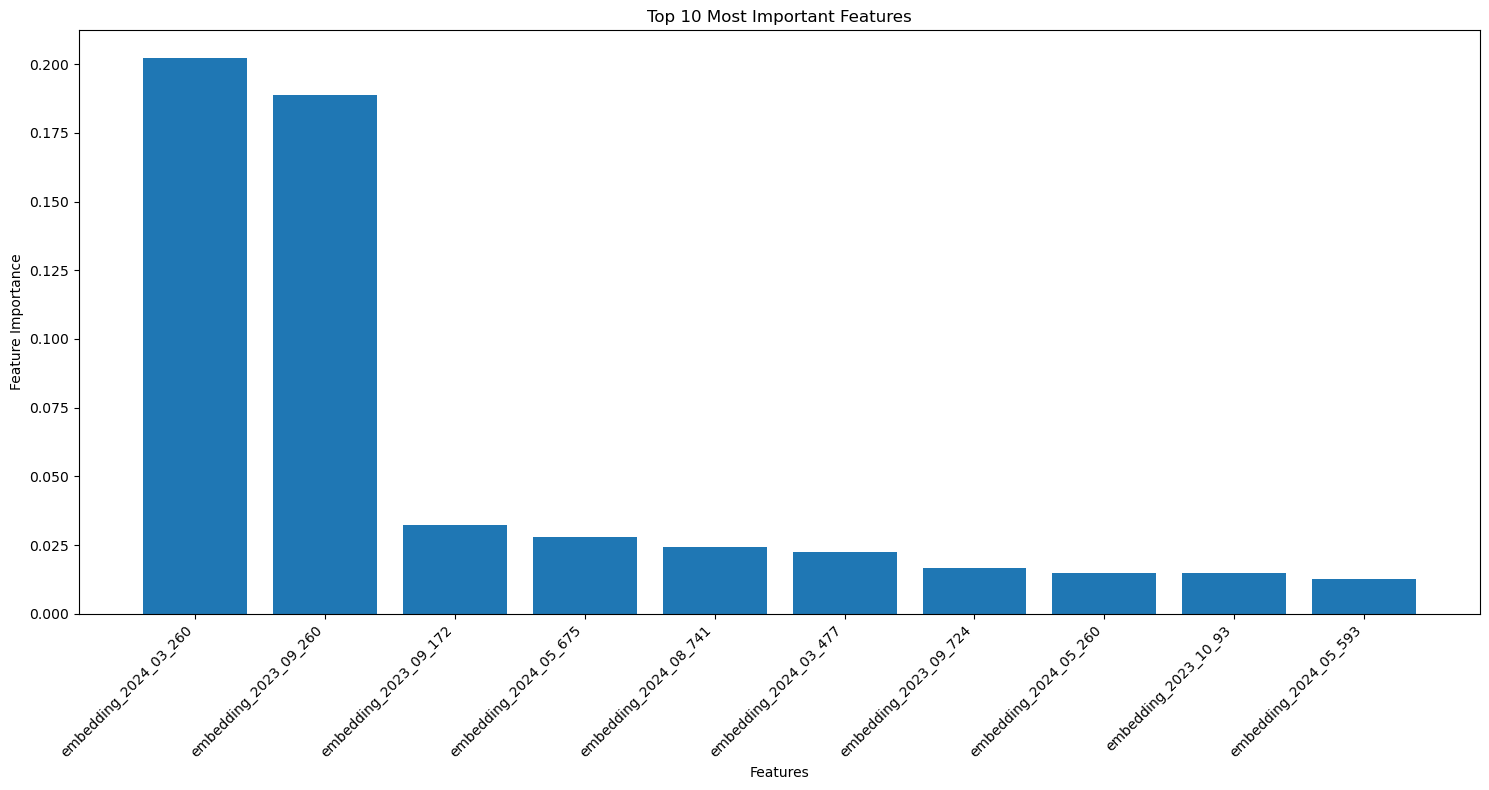

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from model
importances = model.feature_importances_
feature_indices = np.argsort(importances)[::-1][:10]  # Get indices of top 10 features
feature_names = X_train.columns[feature_indices]

# Plot
plt.figure(figsize=(15, 8))
plt.bar(range(10), importances[feature_indices])
plt.xticks(range(10), feature_names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()
